In [36]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Data
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [2]:
df = pd.read_csv('../Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.columns = ['Sales']

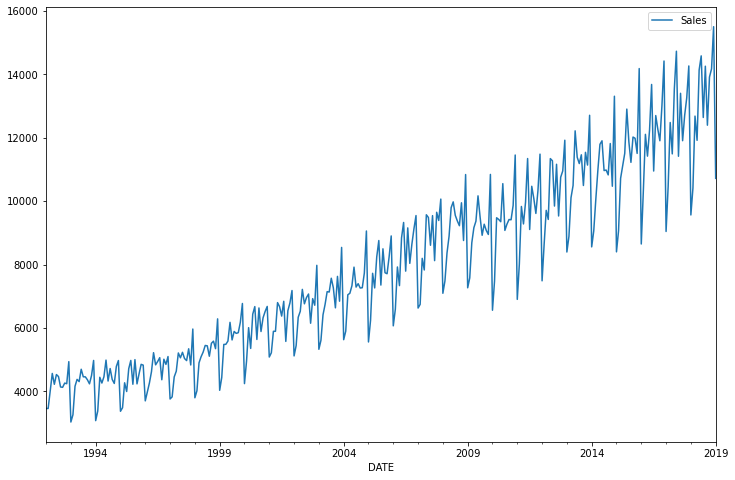

In [5]:
df.plot(figsize=(12,8))

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

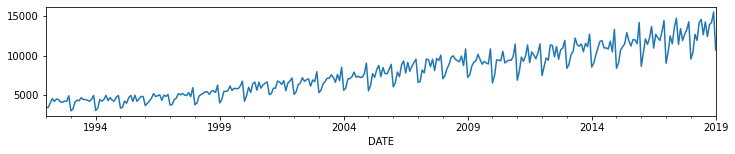

In [9]:
results = seasonal_decompose(df['Sales'])
results.observed.plot(figsize=(12,2))

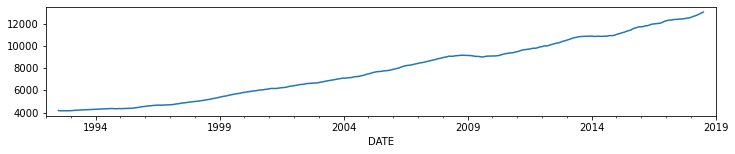

In [10]:
results.trend.plot(figsize=(12,2))

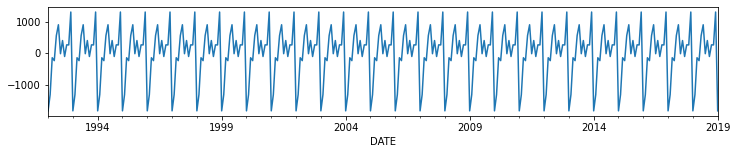

In [11]:
results.seasonal.plot(figsize=(12,2))

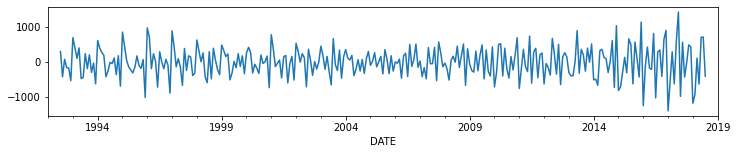

In [12]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [13]:
len(df)

325

In [14]:
325-12

313

In [15]:
train = df.iloc[:313]
test = df.iloc[313:]

In [16]:
len(test)

12

## Scale Data

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [20]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
scaled_train

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ],
       [0.12804513],
       [0.12266006],
       [0.09453799],
       [0.09359774],
       [0.10496624],
       [0.10334217],
       [0.16283443],
       [0.        ],
       [0.0196598 ],
       [0.09650397],
       [0.11505257],
       [0.10906915],
       [0.14231986],
       [0.12197624],
       [0.12189076],
       [0.11394136],
       [0.10300026],
       [0.12556629],
       [0.16608257],
       [0.00376101],
       [0.02957518],
       [0.12069408],
       [0.10513719],
       [0.12214719],
       [0.16702282],
       [0.11052227],
       [0.14428584],
       [0.11479614],
       [0.10402599],
       [0.14984187],
       [0.16582614],
       [0.02897684],
       [0.03872126],
       [0.10582101],
       [0.08231473],
       [0.14394393],
       [0.16608257],
       [0.10188905],
       [0.16830498],
       [0.10291478],
       [0.13018207],
       [0.15556885],
       [0.153

In [69]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(data = scaled_train,
                                targets = scaled_train,
                                length=n_input,
                                batch_size=1)

In [70]:
len(scaled_train)

313

In [71]:
len(generator) # n_input = 2

311

In [72]:
scaled_train[:13]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ],
       [0.12804513],
       [0.12266006],
       [0.09453799],
       [0.09359774],
       [0.10496624],
       [0.10334217],
       [0.16283443],
       [0.        ]])

In [73]:
# What does the first batch look like?
X,y = generator[0]

In [74]:
X.shape

(1, 2, 1)

In [75]:
y.shape

(1, 1)

In [76]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03658432 0.03649885]
Predict this y: 
 [[0.08299855]]


In [77]:
# Let's redefine to get 12 months back and then predict the next month out
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=n_input,
                                batch_size=1)

In [78]:
# What does the first batch look like?
X,y = generator[0]

In [79]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03658432 0.03649885 0.08299855 0.13103684 0.1017181  0.12804513
 0.12266006 0.09453799 0.09359774 0.10496624 0.10334217 0.16283443]
Predict this y: 
 [[0.]]


### Create the Model

In [37]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Sequential

In [38]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [40]:
# fit model
model.fit_generator(generator,epochs=50)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 301 steps
Epoch 1/50
301/301 [==============================] - 3s 9ms/step - loss: 0.0206
Epoch 2/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0094
Epoch 3/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0089
Epoch 4/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0084
Epoch 5/50
301/301 [==============================] - 2s 5ms/step - loss: 0.0067
Epoch 6/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0069
Epoch 7/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0062
Epoch 8/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 9/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 10/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0030
Epoch 11/50
301/301 [==============================] - 1s 5ms/step -

In [41]:
model.history.history.keys()

dict_keys(['loss'])

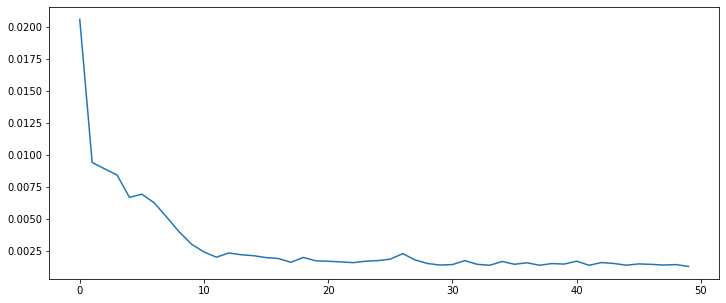

In [82]:
loss_per_epoch = model.history.history['loss']
plt.figure(figsize=(12,5))
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on Test Data

**NN model takes in last 12 data points and predict 13th - so to predict for the test set we will need to give the first evaluation batch**

In [86]:
# last 12 records to predict first step in test data
first_eval_batch = scaled_train[-12:]

In [87]:
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [88]:
# reshaping as per generator - n_input was 12
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [89]:
first_eval_batch.shape

(1, 12, 1)

In [46]:
model.predict(first_eval_batch)

array([[0.678261]], dtype=float32)

In [47]:
scaled_test[0]

array([0.63116506])

Now let's put this logic in a for loop to predict into the future for the entire test range.

## Forecast using RNN

----

In [48]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [49]:
current_batch.shape

(1, 12, 1)

In [50]:
current_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [51]:
# dropping first item and appending 99 as the 12th element
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[ 0.80776135],
        [ 0.72313873],
        [ 0.89870929],
        [ 1.        ],
        [ 0.71672793],
        [ 0.88648602],
        [ 0.75869732],
        [ 0.82742115],
        [ 0.87443371],
        [ 0.96025301],
        [ 0.5584238 ],
        [99.        ]]])

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [52]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [53]:
test_predictions

[array([0.678261], dtype=float32),
 array([0.80827266], dtype=float32),
 array([0.75168085], dtype=float32),
 array([0.92398864], dtype=float32),
 array([1.0069208], dtype=float32),
 array([0.74163043], dtype=float32),
 array([0.9104184], dtype=float32),
 array([0.76074195], dtype=float32),
 array([0.84685254], dtype=float32),
 array([0.88550425], dtype=float32),
 array([0.97455484], dtype=float32),
 array([0.5732106], dtype=float32)]

In [54]:
scaled_test

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

## Inverse Transformations and Compare

In [55]:
true_predictions = scaler.inverse_transform(test_predictions)

In [56]:
true_predictions

array([[10965.97522885],
       [12486.98184675],
       [11824.91427565],
       [13840.74310297],
       [14810.966609  ],
       [11707.33445895],
       [13681.98475897],
       [11930.9200623 ],
       [12938.32787681],
       [13390.51417112],
       [14432.31703514],
       [ 9736.99077475]])

In [57]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [58]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\SwaritSankule\Anaconda3\envs\pyTF2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
test

,Sales,Predictions
DATE,,
2018-02-01,10415,10965.975229
2018-03-01,12683,12486.981847
2018-04-01,11919,11824.914276
2018-05-01,14138,13840.743103
2018-06-01,14583,14810.966609
2018-07-01,12640,11707.334459
2018-08-01,14257,13681.984759
2018-09-01,12396,11930.920062
2018-10-01,13914,12938.327877


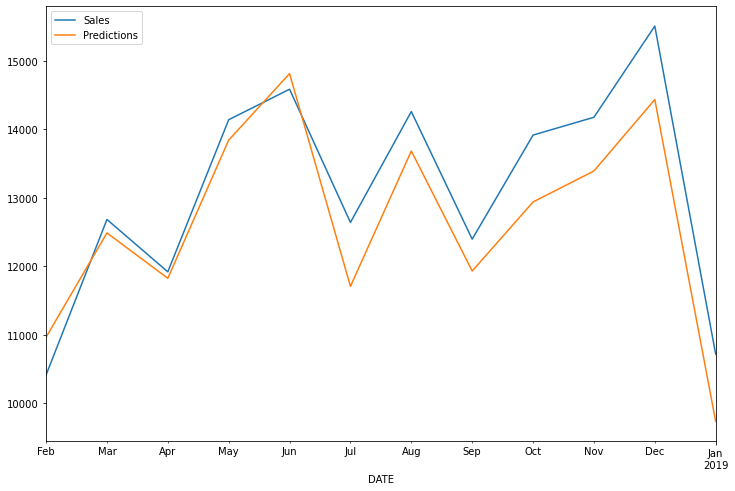

In [60]:
test.plot(figsize=(12,8))

# Saving and Loading Models

In [61]:
model.save('my_rnn_model.h5')

## load a model

In [62]:
from tensorflow.keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [63]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


----